# Курсовая работа № 2
## Аналитика. Начальный уровень

Курсовая работа состоит из двух частей – обязательной и дополнительной. **Для зачета необходимо выполнение только первой части.** Выполнение второй части может потребовать дополнительные знания Python.

- [Часть первая](#Часть-первая)
- [Часть вторая](#Часть-вторая)

## Часть первая


Перед вами стоит задача – подготовить аналитический отчет для HR-отдела. На основании проведенной аналитики предполагается составить рекомендации для отдела кадров по стратегии набора персонала, а также по взаимодействию с уже имеющимися сотрудниками.
<br><br> В базе данных лежит набор таблиц, которые содержат данные о сотрудниках вымышленной компании.
Сделайте обзор штата сотрудников компании. Составьте набор предметов исследования, а затем проверьте их на данных. Вся аналитика должна быть выполена с помощью SQL. Впоследствии данные можно визуализировать, однако финальные датафреймы для графиков также должны быть подготовлены с помощью SQL. <br><br>

Примеры гипотез:
1. Есть зависимость между `perfomance score` и тем, под чьим руководством работает сотрудник.
2. Есть зависимость между продолжительностью работы в компании и семейным положением сотрудника.
2. Есть зависимость между продолжительностью работы в компании и возрастом сотрудника.

<br><br>
Параметры для подключения следующие: хост – `dsstudents.skillbox.ru`, порт – `5432`, имя базы данных – `human_resources`, пользователь – `readonly`, пароль – `6hajV34RTQfmxhS`. Таблицы, доступные для анализа, – `hr_dataset`, `production_staff`, `recruting_costs`, `salary_grid`.

In [117]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pg_connection = {
    "host": "dsstudents.skillbox.ru",
    "port": 5432,
    "dbname": "human_resources",
    "user": "readonly",
    "password": "6hajV34RTQfmxhS"
}

In [97]:
sql_str = "SELECT table_name FROM information_schema.tables WHERE table_schema='public';"

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
cursor.execute(sql_str)
tables_data = [a for a in cursor.fetchall()]
conn.commit()

print("Какие таблицы содержаться в Postgres: %s" % tables_data)

Какие таблицы содержаться в Postgres: [('hr_dataset',), ('production_staff',), ('male',), ('female',), ('recruiting_costs',), ('hr_dataset_view',), ('numb_of_hire',), ('numb_of_terms',), ('salary_grid',), ('days_work',), ('show_functions',), ('abu_pay',), ('abupay1',), ('share_employee_source',), ('tmpDB',), ('abupay',)]


In [136]:
def create_df_from_cursor(cursor):
    df = pd.DataFrame(cursor.fetchall())

    columns = []
    for col in cursor.description:
        columns.append(col.name)
    df.columns = columns
    return df

## Обзор штата

In [129]:
print('Обзор штата')
sql_str = """
    SELECT 
        0 as order_col,
        'Employee count' as param_name,
        COUNT(*) as value        
    FROM hr_dataset
    UNION
    SELECT
        1,
        'Employed now count',
        COUNT(*)
    FROM hr_dataset
    WHERE (empstatus_id = 1) OR (empstatus_id = 3)
    UNION
    SELECT
        2,
        'Terminated count',
        COUNT(*)
    FROM hr_dataset
    WHERE (empstatus_id = 4) OR (empstatus_id = 5)
    UNION
    SELECT
        3,
        CASE WHEN (marriedid = 0) THEN 'Married' ELSE 'Not Married' END as married,
        COUNT(*)
    FROM hr_dataset
    GROUP BY married
    UNION
    SELECT
        4,
        CASE WHEN (genderid = 1) THEN 'Male' ELSE 'Female' END as sex,
        COUNT(*)
    FROM hr_dataset
    GROUP BY genderid
    UNION
    SELECT
        5,
        'Average time employed (days)',
        ROUND(AVG("Days Employed"))
    FROM hr_dataset
    
    
    ORDER BY order_col
        ;
"""

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
cursor.execute(sql_str)

overview_df = create_df_from_cursor(cursor)
conn.close()    
    
overview_df.drop(['order_col'], axis='columns', inplace=True)

overview_df

Обзор штата


,param_name,value
0,Employee count,310
1,Employed now count,197
2,Terminated count,102
3,Not Married,123
4,Married,187
5,Female,177
6,Male,133
7,Average time employed (days),1296


In [92]:
print("Причины уволнения")
sql_str = """
    SELECT 
        "Reason For Term" as reason,
        COUNT(*)        
    FROM hr_dataset
    GROUP BY reason    
        ;
"""

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
cursor.execute(sql_str)

df_term_reasons = create_df_from_cursor(cursor)
conn.close()

df_term_reasons

,reason,count
0,N/A - Has not started yet,11
1,attendance,7
2,more money,11
3,medical issues,3
4,maternity leave - did not return,3
5,return to school,5
6,relocation out of area,5
7,performance,4
8,gross misconduct,1
9,military,4


In [138]:
print("Количество сотрудников по подразделениям")
# количество работающих сотрудников по подразделениям
# данные по отделу Production можно посмотреть в production_staff, разница на 1 человека, для общего обзора несущественно.
sql_str = """
    SELECT 
        department,
        COUNT(*)        
    FROM hr_dataset
    WHERE (empstatus_id = 1) OR (empstatus_id = 3)
    GROUP BY department
    ;
"""

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
cursor.execute(sql_str)
                 
df_departments = create_df_from_cursor(cursor)

conn.close()

df_departments

Количество сотрудников по подразделениям


,department,count
0,Production,117
1,Admin Offices,8
2,IT/IS,38
3,Executive Office,1
4,Software Engineering,7
5,Sales,26


## Проверка гипотез

Есть зависимость между полом и временем работы в организации

Вывод: явной зависимости между полом, и временем работы на предприятии не наблюдается. Можем только наблюдать, что в подразделении "Admin Offices" женщины в среднем работают дольше, чем мужчины. А в подразделении Executive Office работают только женщины (но это CEO, и она не менялась за время, за которое есть данные).

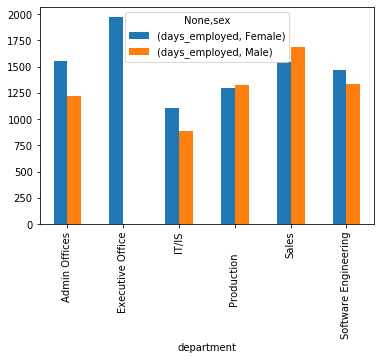

In [295]:
sql_str = """
    SELECT 
        department,
        CASE WHEN (genderid = 1) THEN 'Male' ELSE 'Female' END as sex,
        ROUND(AVG("Days Employed")) as days_employed
    FROM hr_dataset
    GROUP BY department, genderid
    ORDER BY department
    ;
"""

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
cursor.execute(sql_str)
                 
df_temp = create_df_from_cursor(cursor)

conn.close()

df_temp.set_index(['department', 'sex'], inplace=True)
df_temp['days_employed'] = pd.to_numeric(df_temp['days_employed'])
df_temp.unstack().plot.bar()

Есть зависимость между зарплатой и менеджером в производственном подразделении

Вывод: Есть =)))
У менеджеров, которыми руководит Elisa Bramante зарплаты значительно выше, чем у Технологов разных категорий.

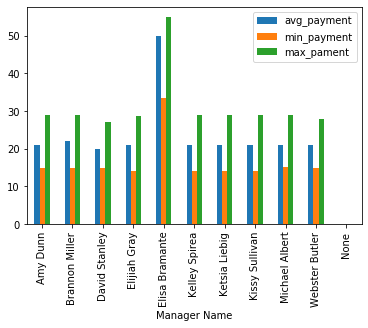

In [180]:
sql_str = """
    SELECT 
        --"Position",
        "Manager Name",
        ROUND(AVG("Pay"::money::numeric::float8)) as avg_payment,
        MIN("Pay"::money::numeric::float8) as min_payment,
        MAX("Pay"::money::numeric::float8) as max_pament
    FROM production_staff
    --GROUP BY "Position", "Manager Name"
    GROUP BY "Manager Name"
    ORDER BY "Manager Name"
    ;
"""

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
cursor.execute(sql_str)
                 
df_temp = create_df_from_cursor(cursor)

conn.close()

df_temp.set_index(['Manager Name'], inplace=True)
df_temp.plot.bar()

In [183]:
sql_str = """
    SELECT 
        "Position",
        "Manager Name",
        ROUND(AVG("Pay"::money::numeric::float8)) as avg_payment,
        MIN("Pay"::money::numeric::float8) as min_payment,
        MAX("Pay"::money::numeric::float8) as max_pament
    FROM production_staff
    GROUP BY "Position", "Manager Name"
    ORDER BY "Manager Name"
    ;
"""

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
cursor.execute(sql_str)
                 
df_temp = create_df_from_cursor(cursor)

conn.close()

df_temp.set_index(['Manager Name', 'Position'], inplace=True)
df_temp

avg_payment  min_payment  max_pament
Manager Name   Position                                                      
Amy Dunn       Production Technician II         25.0        22.00       29.00
               Production Technician I          20.0        15.00       24.00
Brannon Miller Production Technician I          20.0        15.00       24.75
               Production Technician II         26.0        25.00       29.00
David Stanley  Production Technician I          18.0        15.00       22.00
               Production Technician II         25.0        22.00       27.00
Elijiah Gray   Production Technician I          19.0        14.00       23.00
               Production Technician II         26.0        22.00       28.75
Elisa Bramante Production Manager               50.0        33.50       55.00
Kelley Spirea  Production Technician I          18.0        14.00       24.00
               Production Technician II         26.0        22.00       29.00
Ketsia Liebig  Production Technician II         25.0        22.00       29.00
               Production Technician I          19.0        14.00       24.50
Kissy Sullivan Production Technician I          19.0        14.00       24.00
               Production Technician II         26.0        22.00       29.00
Michael Albert Production Technician II         26.0        23.00       29.00
               Production Technician I          19.0        15.25       24.00
Webster Butler Production Technician I          19.0        15.00       24.00
               Production Technician II         24.0        22.00       28.00
NaN            NaN                               NaN          NaN         NaN

Есть зависимость между рассой и ЗП в производственном подразделении (в рамках одинаковых должностей)

Дополнительно показаны данные по количеству сотрудников каждой рассы (в рамках должности)

Вывод: Испанцы, индейцы и сотрудники со смешанной рассой получают в среднем меньше, чем белые, азиаты и афроамериканцы.
Но так как количество работающих в производственном подразделении испанцев, индейцев и людей со смешанной рассой значительно меньше, чем представителей других рас, то вывод сложно назвать точным.


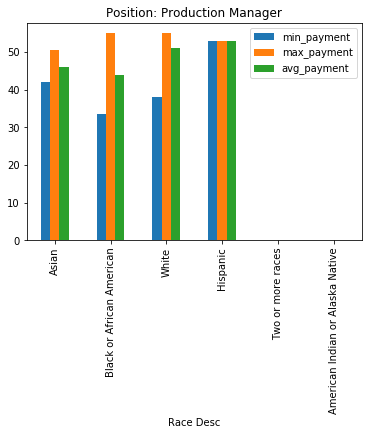

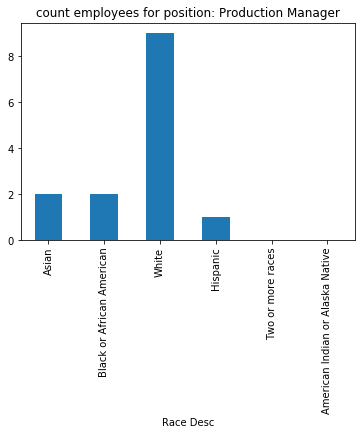

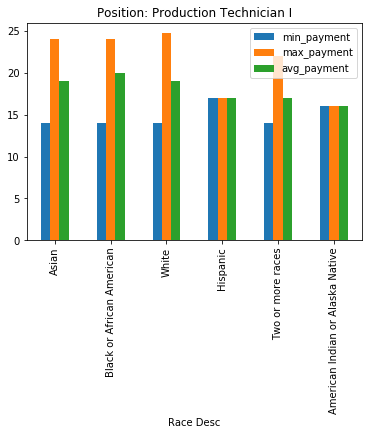

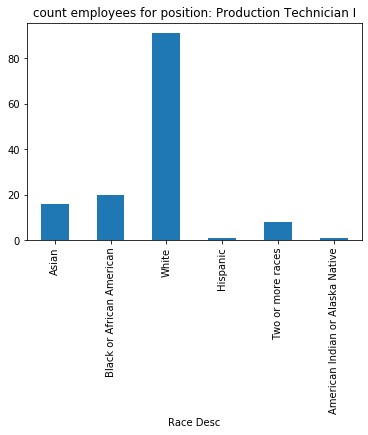

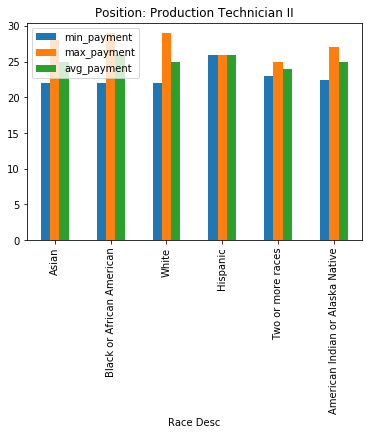

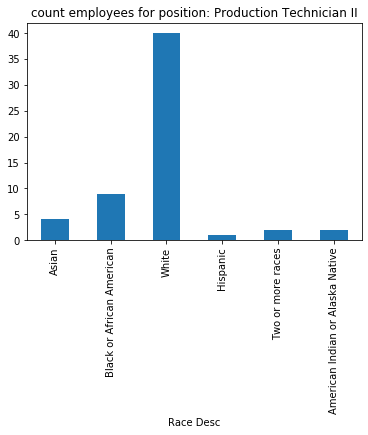

In [218]:
sql_str = """
    SELECT 
        "Position",
        "Race Desc",
        ROUND(AVG("Pay"::money::numeric::float8)) as avg_payment,
        MIN("Pay"::money::numeric::float8) as min_payment,
        MAX("Pay"::money::numeric::float8) as max_payment,
        COUNT(*) as count_employees
    FROM production_staff
    WHERE "Position" IS NOT NULL
    GROUP BY "Position", "Race Desc"
    ORDER BY "Position"
    ;
"""

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
cursor.execute(sql_str)
                 
df_temp = create_df_from_cursor(cursor)

conn.close()

races = list(df_temp['Race Desc'].drop_duplicates())

df_temp.set_index(['Position', 'Race Desc'], inplace=True)

for position in df_temp.index.get_level_values('Position').drop_duplicates():
    df_temp.loc[position].reindex(races)[['min_payment', 'max_payment', 'avg_payment']].plot.bar(title=f'Position: {position}')
    plt.figure()
    df_temp.loc[position].reindex(races)['count_employees'].plot.bar(title=f'count employees for position: {position}')

Сезонность расходов на рекрутинг

january       4389
february     10032
march         6343
april         5881
may           5209
june          6616
july          5652
august       11177
september     8807
october       7278
november      6584
december      6497
dtype: int64

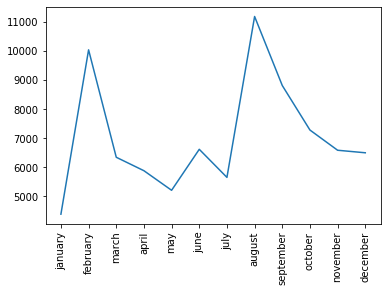

In [294]:
sql_str = """
    SELECT 
        SUM("January ") as january, 
        SUM("February") as february, 
        SUM("March") as march, 
        SUM("April") as april, 
        SUM("May") as may, 
        SUM("June") as june, 
        SUM("July") as july, 
        SUM("August") as august, 
        SUM("September") as september, 
        SUM("October") as october, 
        SUM("November") as november, 
        SUM("December") as december
    FROM recruiting_costs
    ;
"""

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
cursor.execute(sql_str)
                 
df_recruting_costs = create_df_from_cursor(cursor)
df_recruting_costs = df_recruting_costs.stack()[0]

conn.close()

plt.xticks(rotation='vertical')
plt.plot(df_recruting_costs)

df_recruting_costs

Сезонность увольнений

,month_name,count_terms,index,0
0,january,9000,january,4389
1,february,9000,february,10032
2,march,2000,march,6343
3,april,14000,april,5881
4,may,10000,may,5209
5,june,12000,june,6616
6,july,3000,july,5652
7,august,9000,august,11177
8,september,20000,september,8807
9,october,4000,october,7278


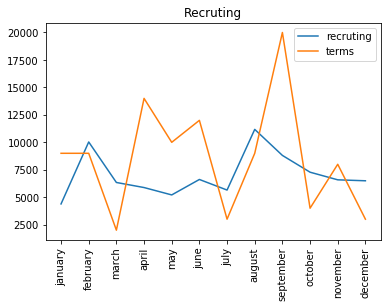

In [293]:
sql_str = """
    SELECT 
        EXTRACT (MONTH FROM "Date of Termination") AS Month,
        BTRIM(TO_CHAR("Date of Termination", 'month'), ' ') AS Month_name,
        COUNT(*) * 1000 as count_terms
    FROM hr_dataset
    WHERE "Date of Termination" IS NOT NULL
    GROUP BY 
        EXTRACT (MONTH FROM "Date of Termination"), 
        TO_CHAR("Date of Termination", 'month')
    ORDER BY Month
    ;
"""

conn = psycopg2.connect(**pg_connection)
cursor = conn.cursor()
cursor.execute(sql_str)
                 
df_temp = create_df_from_cursor(cursor)

conn.close()

df_temp.set_index('month', inplace=True)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title('Recruting')

plt.xticks(rotation='vertical')
ax.plot(df_recruting_costs, label='recruting')
ax.plot(df_temp.month_name, df_temp.count_terms, label='terms')
ax.legend()

# df = df_temp.merge(df_recruting_costs.to_frame().reset_index(), how='outer', left_on='month_name', right_on='index')

Выводы по сезонности:
На рекрутинг в феврале и августе-сентябре расходы выше, чем в остальных месяцах.
Количество увольнений увеличивается в апреле-июне и сентябре.

При этом явную корреляцию между сезонностью рекрутинга и увольнений зафиксировать сложно. Но если такая сезонность повторяется из года в год, то можно сказать, что затраты на подбор персонала заблаговременно увеличиваются, чтобы компенсировать увольнения. Это может быть также связано с плановым расширением штата.


## Часть вторая

Перед вами стоит задача – подготовить аналитический ответ для SMM-отдела компании Skillbox. <br> Объектом анализа является  [паблик Skillbox Вконтакте](https://vk.com/skillbox_education). <br> <br> 
Подключитесь к  API VK и выгрузите посты со стены паблика Skillbox за интересующий период (определите самостоятельно и обоснуйте). Проанализируйте влияние различных факторов (например, времени публикации) на вовлеченность пользователей (количество лайков, комментариев, голосов в опросах). Сделайте аналитику по рубрикам (примеры рубрик: дизайн-битва, игра по управлению), которые есть в паблике. Выбрать нужные посты можно с помощью регулярных выражений. Составьте перечень рекомандаций для SMM-отдела по итогам анализа. <br> <br> 

Дополнительные инструкции по работе с API VK расположены [здесь](https://nbviewer.jupyter.org/github/vikaborel/dstutorials/blob/master/Дополнительные%20инструкции.ipynb).

### Подготовка данных

In [193]:
import requests
import pandas as pd
import numpy as np
import re
import seaborn as sns

def getjson(url):
    response = requests.get(url)
    response = response.json()
    return response


In [23]:
vk_token = 'ad57e4f1ae296ac43be8ee6a55a72295c6b088ca7956def5085cd39b6707d5f2892f88e17f89f3a5d89e1'

# url = 'https://api.vk.com/method/account.getProfileInfo?access_token=' + str(vk_token) + '&v=5.92'
# response = getjson(url)

# print(response)

In [154]:
# Можно посмотреть по ближайшей паре тысяч пабликов, где взлёты, или наоборот, провалы в вовлеченности и проанализировать потом 
# этот период. То есть сделать 10-20 запросов по 100 сообщений, 
# вычленить оттуда даты публикаций, может хэштеги, охваты и другую информацию. 
# Взять аномальный интервал или наоборот самый типовой, 

step = 100
dates = []
likes = []
comments = []
reposts = []
views = []

# для поиска хэштегов возьмём слова, начинающиеся с # (даже если подряд идут). Добавим туда возможное дополнение 
# в виде @<необязательное слово>
# и исключим решётки в ссылках.
reg_expr = r'\s#\w+@?\w*'
reg_expr_compiled = re.compile(reg_expr)
tags=[]
len_texts=[]

poll_votes=[]

for i in range(0, 2000, step):
    url = 'https://api.vk.com/method/wall.get?access_token=' + \
          str(vk_token) + '&owner_id=-66669811&offset=' + str(i) + '&count=' + str(step) + '&v=5.92'
    response = getjson(url)
    for res_item in response['response']['items']:
        dates.append(pd.to_datetime(res_item['date'], unit='s'))
        likes.append(res_item['likes']['count'])
        comments.append(res_item['comments']['count'])
        reposts.append(res_item['reposts']['count'])
        views.append(res_item['views']['count'])

        text = res_item['text']
        cur_tags=[]
        for tag in reg_expr_compiled.findall(text):
            cur_tags.append(tag.strip())
        tags.append(cur_tags)
        len_texts.append(len(text))
        
        votes = None
        if 'attachments' in res_item:
            for attach in res_item['attachments']:
                if isinstance(attach, dict) and ('poll' in attach):
                    votes = (attach['poll']['votes'])
        poll_votes.append(votes)

In [155]:
df = pd.DataFrame(list(zip(dates, likes, comments, reposts, views, tags, len_texts, poll_votes)), 
                  columns =['date', 'likes', 'comments', 'reposts', 'views', 'tags', 'len_texts', 'poll_votes'])
df

,date,likes,comments,reposts,views,tags,len_texts,poll_votes
0,2020-06-17 16:37:01,17,8,2,7610,[#Статья_Skillbox],195,NaN
1,2020-06-17 11:00:20,15,0,1,9201,"[#Анонс_Skillbox, #Skillbox_управление]",1860,NaN
2,2020-06-16 16:11:28,22,3,2,12623,[#Лекторий_Skillbox],953,NaN
3,2020-06-15 16:45:50,94,17,16,16726,"[#Статья_Skillbox, #Skillbox_Дизайн]",205,NaN
4,2020-06-15 15:09:03,31,0,1,15275,[#Расписание_Skillbox],597,NaN
...,...,...,...,...,...,...,...,...
1995,2018-06-14 11:00:12,194,7,18,145399,[#read@skillbox_education],376,NaN
1996,2018-06-13 12:30:00,48,0,7,57057,[#desing@skillbox_education],696,NaN
1997,2018-06-13 10:38:58,22,0,1,4926,[],288,NaN
1998,2018-06-12 16:30:00,24,4,0,6608,[],107,NaN


In [156]:
# выделим колонки с днём недели и часом публикации. Интервалы часов пока не будем делать.
df['weekday'] = df['date'].dt.weekday
df['hour'] = df['date'].dt.hour

In [157]:
# посчитаем коэффициент вовлеченности на охват: engagement rate by reach 
# views больше похоже на просмотры, чем на охват, но параметров, связанных непосредственно с охватом не нашла
df['ERR'] = ((df['likes'] + df['comments'] + df['reposts'])/df['views']) * 100

In [173]:
# посмотрим вовлеченность на охват в разрезе тэгов
def print_ERR_by_tags(base_df):
    df_ERR_by_tags = base_df.explode('tags')
    df_ERR_by_tags = df_ERR_by_tags.groupby('tags')[['ERR', 'likes', 'comments', 'reposts', 'views']].agg(['median', 'count'])
    df_ERR_by_tags = df_ERR_by_tags[df_ERR_by_tags['likes', 'count'] >= 15]
    df_ERR_by_tags = df_ERR_by_tags.stack(level=0)\
                                    .drop('count', axis='columns')\
                                    .unstack()['median']\
                                    .sort_values('ERR', ascending=False)
    # df_ERR_by_tags
    for col in df_ERR_by_tags.columns:
        fig = plt.figure(figsize=(12.8, 4.8))
        ax = plt.subplot(111)
        ax.set_title(f'{col} by tags')
        plt.xticks(rotation='vertical')
        ax.plot(df_ERR_by_tags[col].sort_values(ascending=False))

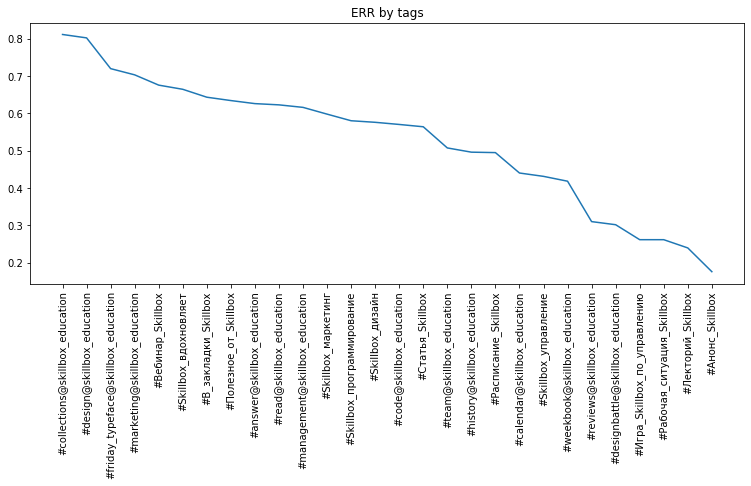

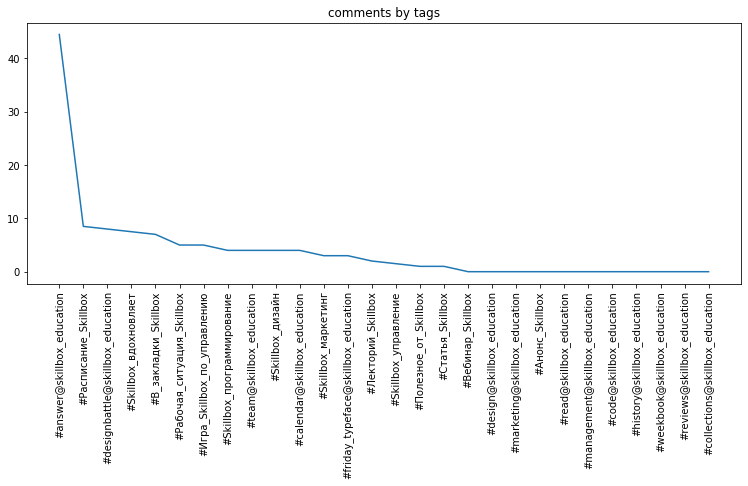

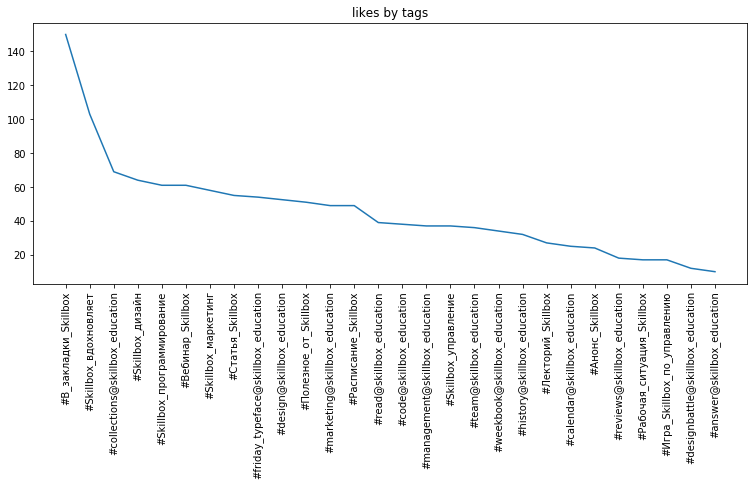

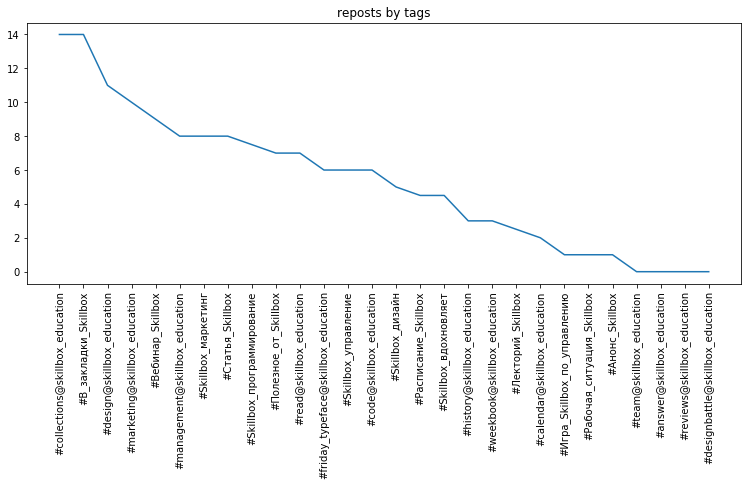

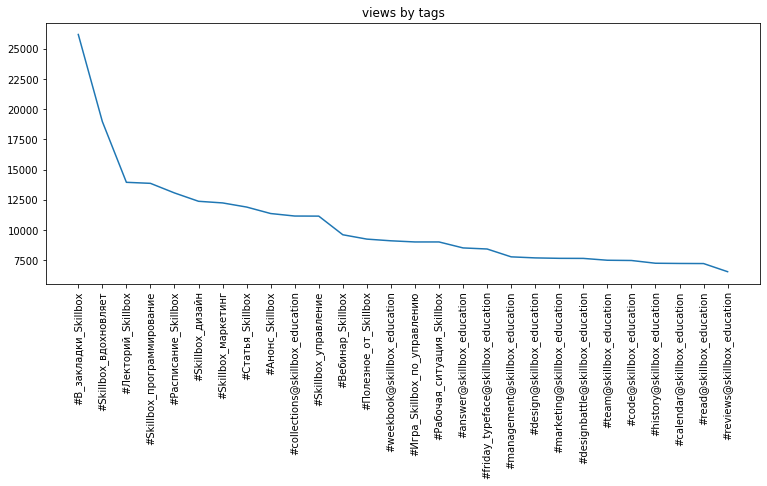

In [174]:
print_ERR_by_tags(df)

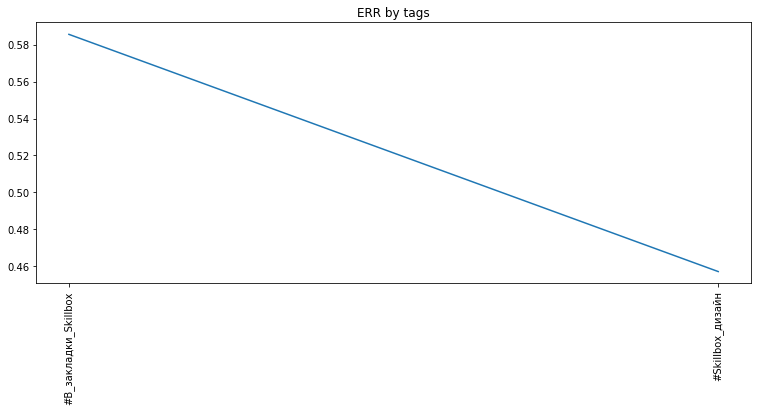

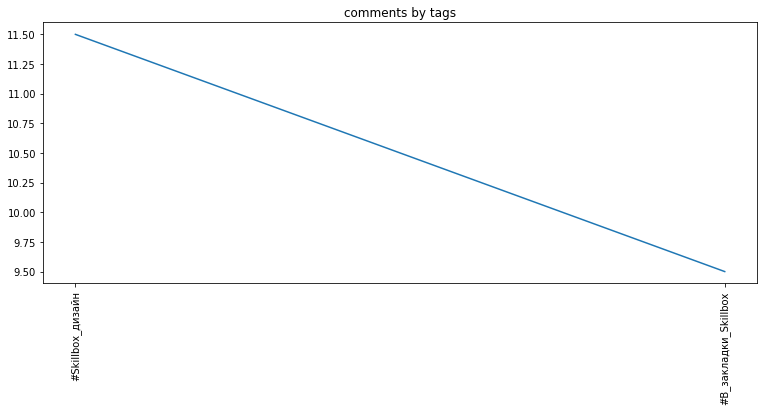

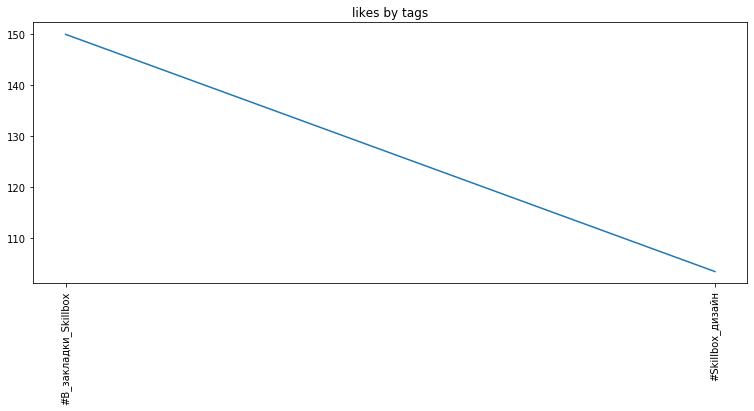

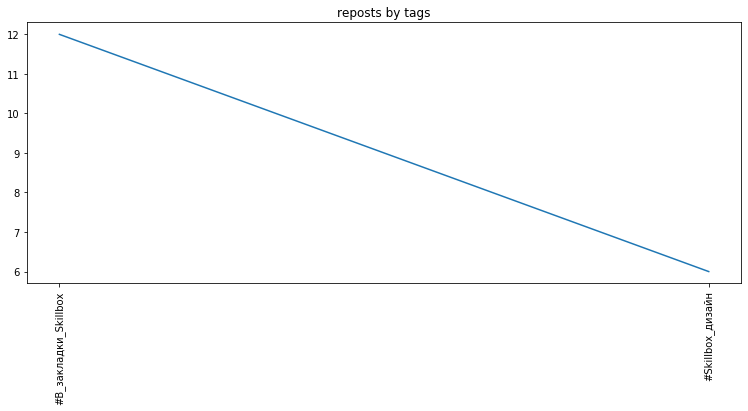

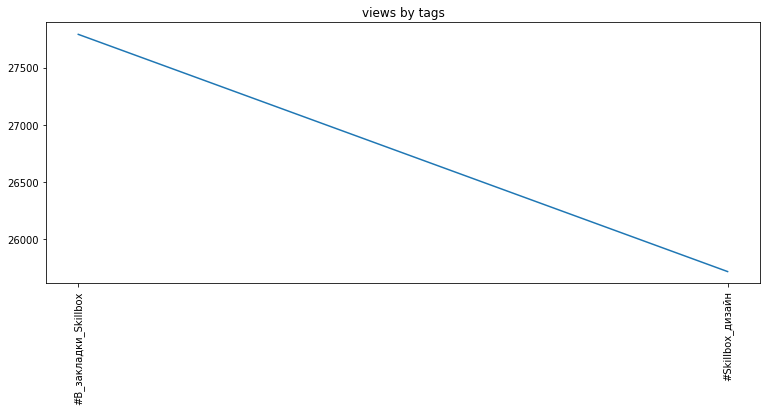

In [175]:
print_ERR_by_tags(df[df['date'] > (pd.to_datetime('now') - pd.Timedelta('60 days'))])
# очень мало разделов в последние 60 дней, выделенных хэштегами. Хорошо бы разнообразить материал, если не предполагается, 
# что ЦА паблика - в основном дизайнеры

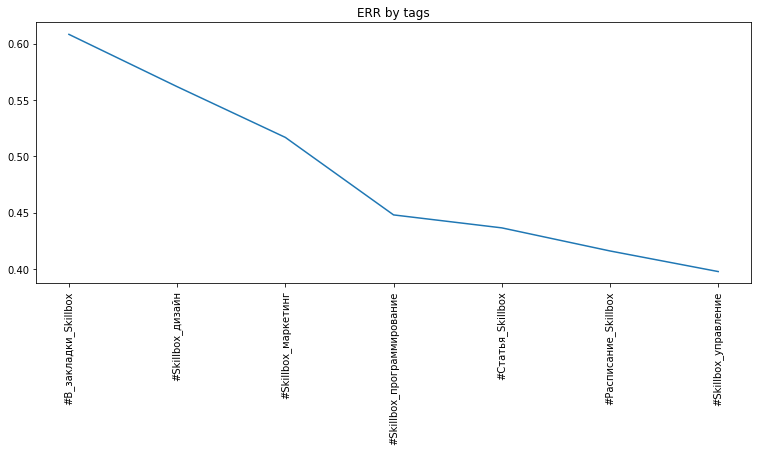

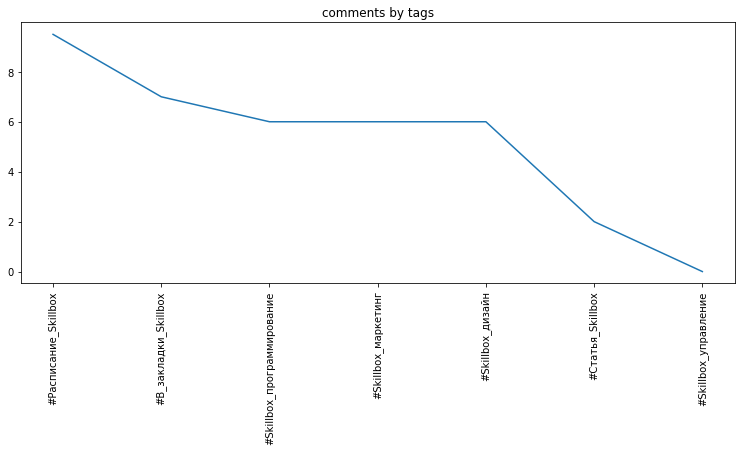

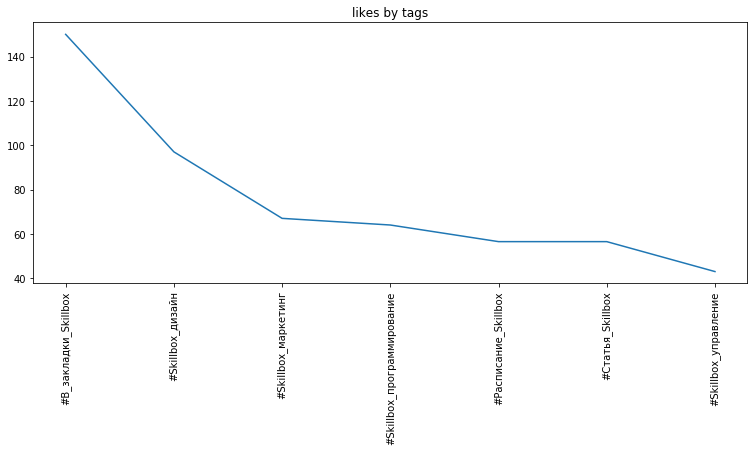

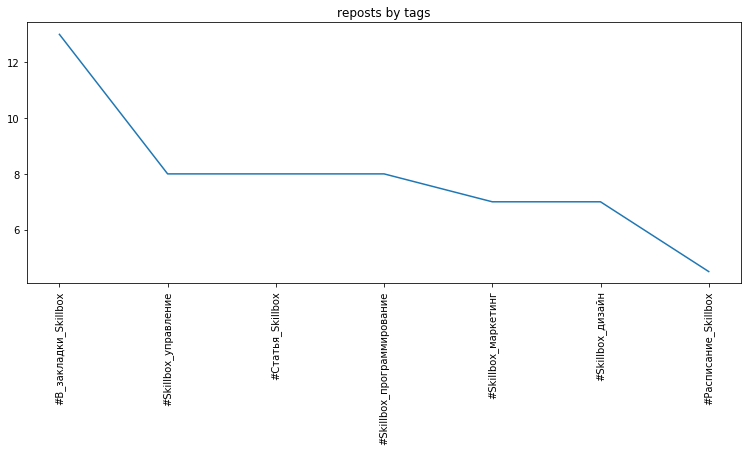

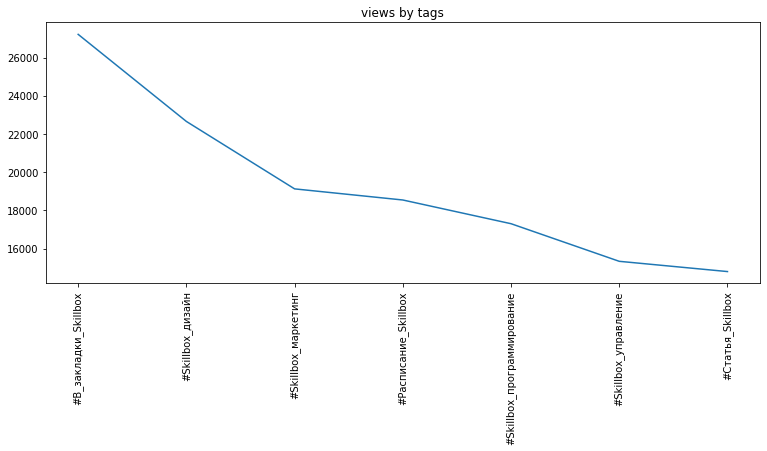

In [176]:
print_ERR_by_tags(df[df['date'] > (pd.to_datetime('now') - pd.Timedelta('180 days'))])
# последние полгода +-.
# Самый популярный хештег - "В_закладки_Skillbox".

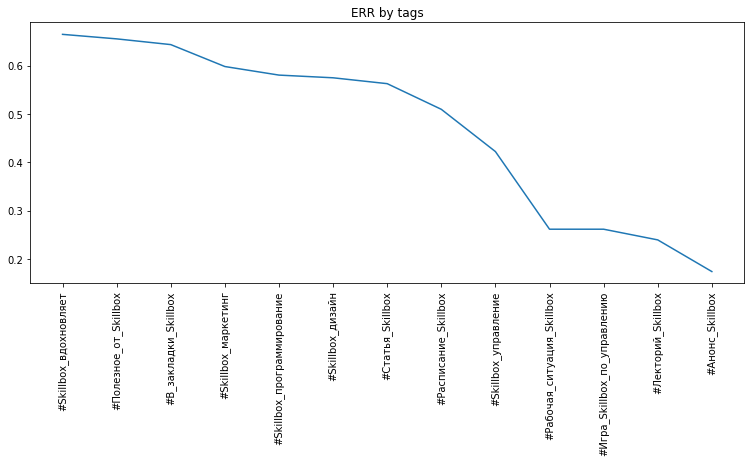

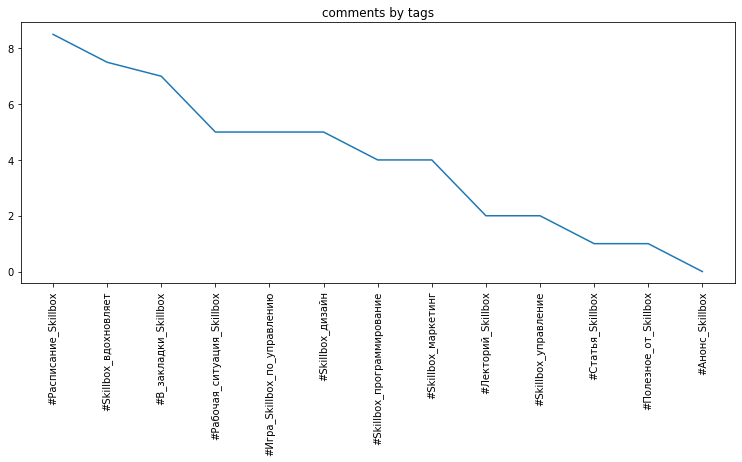

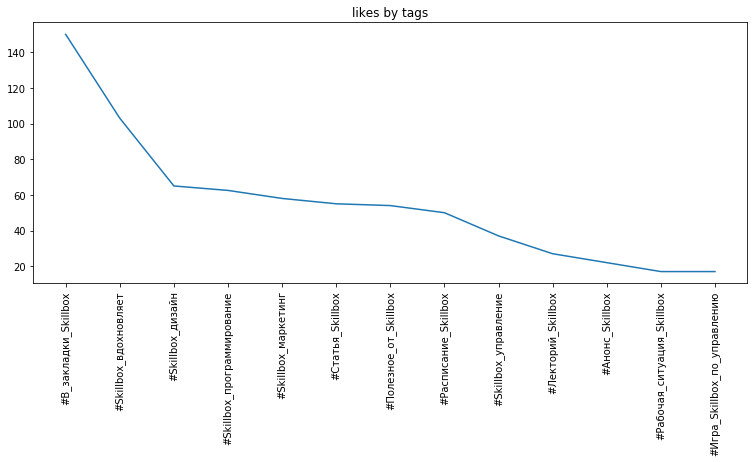

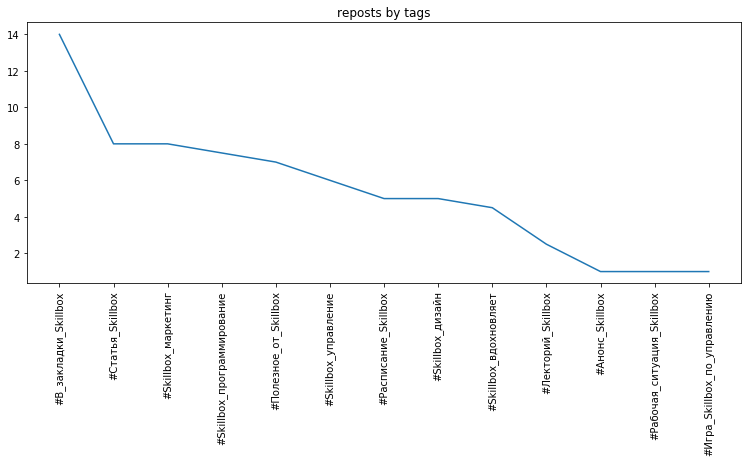

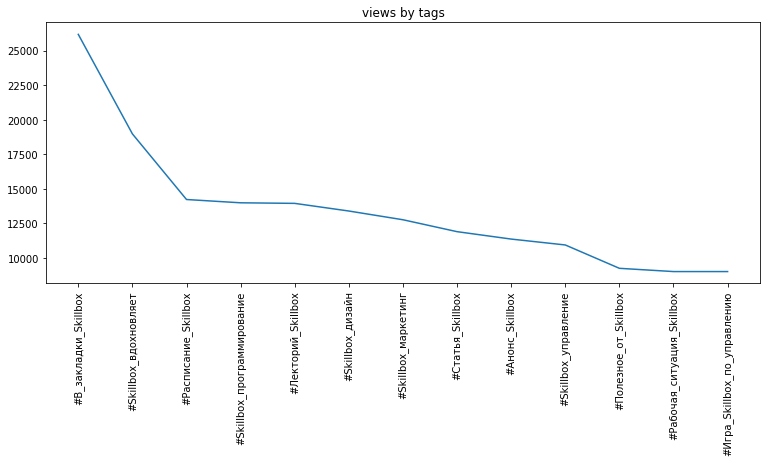

In [177]:
print_ERR_by_tags(df[df['date'] > (pd.to_datetime('20200101') - pd.Timedelta('180 days'))])

In [194]:
df.sort_values('views', ascending=False).head(20)
# По охвату можно взять 6-7 месяц 18-го года, посмотреть зависимость охвата от разных признаков
# по факту оказалось, что это разовые выбросы, возможно, реклама.

,date,likes,comments,reposts,views,tags,len_texts,poll_votes,weekday,hour,ERR
1995,2018-06-14 11:00:12,194,7,18,145399,[#read@skillbox_education],376,NaN,3,11,0.150620
392,2019-11-10 09:35:11,68,34,3,122759,"[#Skillbox_Sreda, #Skillbox_конкурс]",607,NaN,6,9,0.085533
1918,2018-07-11 12:30:01,210,5,39,103872,[#design@skillbox_education],497,NaN,2,12,0.244532
787,2019-05-20 10:10:08,198,44,12,95792,[],809,NaN,0,10,0.265158
52,2020-05-13 13:32:38,882,802,212,85929,"[#Конкурс_Skillbox, #Skillbox_TED]",721,NaN,2,13,2.206473
1990,2018-06-15 14:30:02,464,0,105,85300,"[#desing@skillbox_education, #collections@skil...",513,NaN,4,14,0.667057
1028,2019-03-10 07:30:00,735,0,217,78991,[#collections@skillbox_education],197,NaN,6,7,1.205201
1976,2018-06-21 12:30:01,64,0,8,78786,[#design@skillbox_education],659,NaN,3,12,0.091387
1846,2018-07-30 14:30:01,172,0,37,78115,"[#read@skillbox_education, #design@skillbox_ed...",408,NaN,0,14,0.267554
1972,2018-06-22 14:30:02,682,0,206,77776,"[#marketing@skillbox_education, #collections@s...",722,NaN,4,14,1.141740


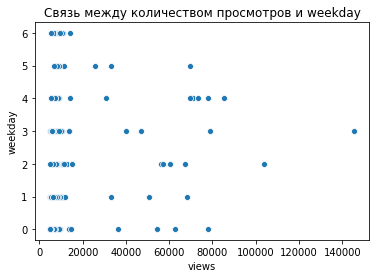

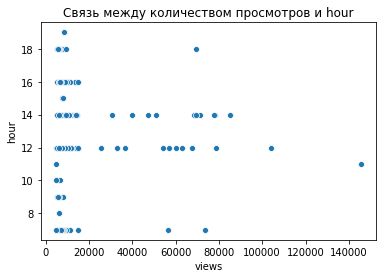

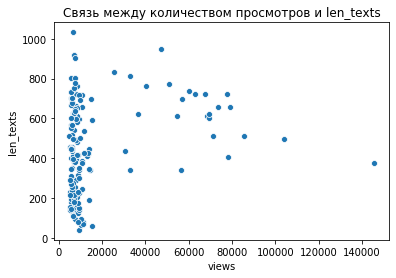

In [196]:
# посмотрим диаграмму рассеяния для зависимости просмотров от дня недели, часа и длины текста.
# за период до 8-го месяца 2018-го года
research_list = ["weekday", "hour", "len_texts", 'views']
df_for_scatter = df[df['date'] < pd.to_datetime('20180801')]
for i in research_list[:-1]:
    sns.scatterplot(x="views", y=i, data=df_for_scatter)
    plt.title("Связь между количеством просмотров и " + str(i))
    plt.show()
    
# можем увидеть, что в целом количество просмотров находятся в определённом диапазоне, и только единичные записи выделяются.
# это могут быть рекламные записи
# Можно отметить, что записи, опубликованные в пт имели большее количество просмотров.
# Что касается времени, количество просмотров большее у публикаций, сделанных с 12 до 14 часов.

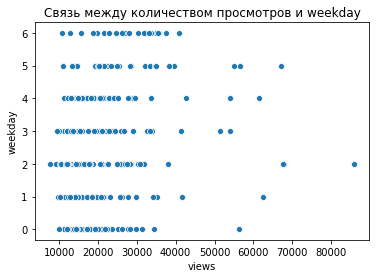

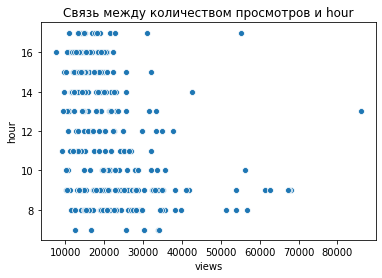

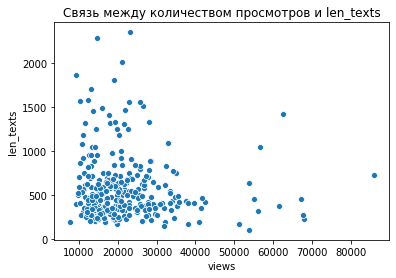

In [207]:
# посмотрим диаграмму рассеяния для зависимости просмотров от дня недели, часа и длины текста.
# за период - последние 180 дней. Количество подписчиков меняется, показатели и подходы тоже. Актуально анализировать последние.
research_list = ["weekday", "hour", "len_texts", "views"]
df_for_scatter = df[df['date'] > (pd.to_datetime('now') - pd.Timedelta('180 days'))]
for i in research_list[:-1]:
    sns.scatterplot(x="views", y=i, data=df_for_scatter)
    plt.title("Связь между количеством просмотров и " + str(i))
    plt.show()
    
# можно отметить, что есть записи, опубликованные во вторник, с меньшим, чем обычно, количеством просмотров. 
# Хотя верно и обратное. Можно дополнительно посмотреть распределение просмотров по часа внутри каждого дня недели.
# В целом нельзя сказать, что какой-либо день недели сильно выделяется среди остальных.
# В 

In [40]:
df.sort_values('likes', ascending=False).head(20)
# По лайкам можно взять 5-6 месяц 20-го года, посмотреть зависимость лайков от разных признаков

,date,likes,comments,reposts,views
1205,2019-01-25 10:00:13,1112,2,1,9206
909,2019-04-07 07:30:00,978,7,304,72481
61,2020-05-06 09:20:16,929,20,179,67939
51,2020-05-13 13:32:38,881,802,215,85872
747,2019-06-02 07:30:00,796,9,231,67381
1027,2019-03-10 07:30:00,735,0,217,78991
1971,2018-06-22 14:30:02,682,0,206,77776
336,2019-12-04 16:00:01,643,5,128,51054
210,2020-02-11 09:22:05,610,0,108,62556
964,2019-03-24 07:30:00,586,10,173,71164


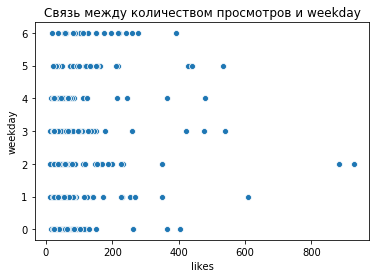

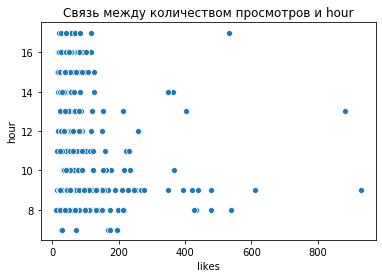

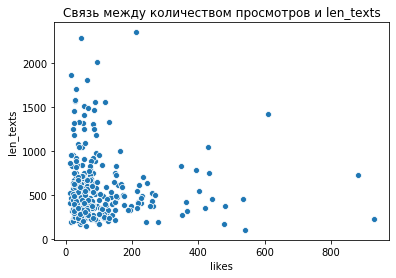

In [210]:
# посмотрим диаграмму рассеяния для зависимости лайков от дня недели, часа и длины текста.
# за период - последние 180 дней.
research_list = ["weekday", "hour", "len_texts", "likes"]
df_for_scatter = df[df['date'] > (pd.to_datetime('now') - pd.Timedelta('180 days'))]
for i in research_list[:-1]:
    sns.scatterplot(x="likes", y=i, data=df_for_scatter)
    plt.title("Связь между количеством просмотров и " + str(i))
    plt.show()

In [208]:
df.sort_values('ERR', ascending=False).head(20)

,date,likes,comments,reposts,views,tags,len_texts,poll_votes,weekday,hour,ERR
1206,2019-01-25 10:00:13,1112,2,1,9206,[],0,NaN,4,10,12.111666
1130,2019-02-14 10:00:16,383,26,28,16996,[],0,NaN,3,10,2.571193
134,2020-03-23 13:33:23,403,107,86,23520,[#Skillbox],543,NaN,0,13,2.534014
511,2019-09-12 15:00:04,249,0,51,13457,"[#Статья_Skillbox, #Skillbox_дизайн]",335,NaN,3,15,2.229323
52,2020-05-13 13:32:38,882,802,212,85929,"[#Конкурс_Skillbox, #Skillbox_TED]",721,NaN,2,13,2.206473
329,2019-12-09 09:19:19,318,12,81,20249,"[#В_закладки_Skillbox, #Skillbox_маркетинг]",1508,NaN,0,9,2.029730
1784,2018-08-17 14:30:00,187,4,41,11501,"[#collections@skillbox_education, #marketing@s...",784,NaN,4,14,2.017216
1715,2018-09-06 12:30:02,154,3,35,9986,"[#read@skillbox_education, #design@skillbox_ed...",369,NaN,3,12,1.922692
910,2019-04-07 07:30:00,978,7,304,72485,[],255,NaN,6,7,1.778299
1808,2018-08-10 14:30:02,151,1,32,10452,"[#collections@skillbox_education, #design@skil...",450,NaN,4,14,1.760429


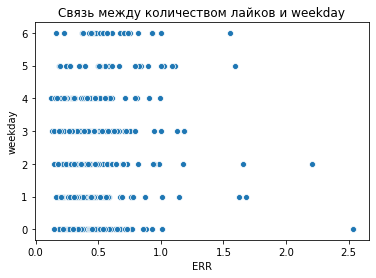

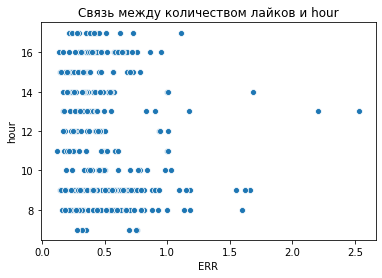

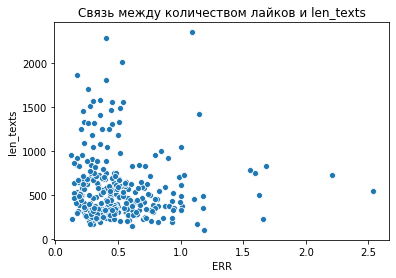

In [214]:
# посмотрим диаграмму рассеяния для зависимости просмотров от дня недели, часа и длины текста.
# за период - последние 180 дней. Количество подписчиков меняется, показатели и подходы тоже. Актуально анализировать последние.
research_list = ["weekday", "hour", "len_texts", "ERR"]
df_for_scatter = df[df['date'] > (pd.to_datetime('now') - pd.Timedelta('180 days'))]
for i in research_list[:-1]:
    sns.scatterplot(x="ERR", y=i, data=df_for_scatter)
    plt.title("Связь между количеством лайков и " + str(i))
    plt.show()

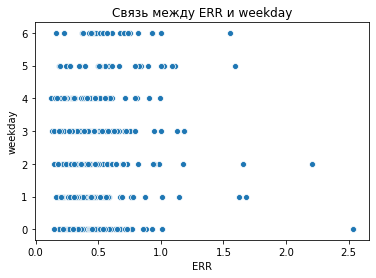

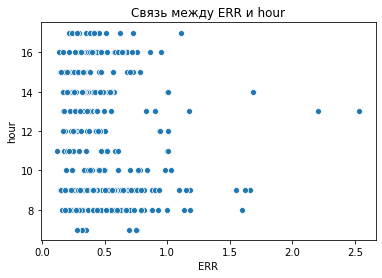

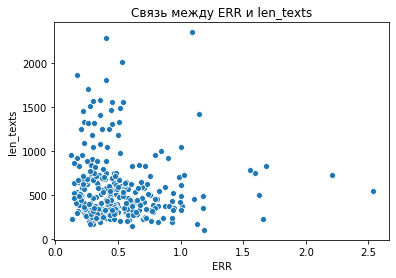

In [213]:
# посмотрим диаграмму рассеяния для зависимости ERR от дня недели, часа и длины текста.
# за период - последние 180 дней. Количество подписчиков меняется, показатели и подходы тоже. Актуально анализировать последние.
research_list = ["weekday", "hour", "len_texts", "ERR"]
df_for_scatter = df[df['date'] > (pd.to_datetime('now') - pd.Timedelta('180 days'))]
for i in research_list[:-1]:
    sns.scatterplot(x="ERR", y=i, data=df_for_scatter)
    plt.title("Связь между ERR и " + str(i))
    plt.show()

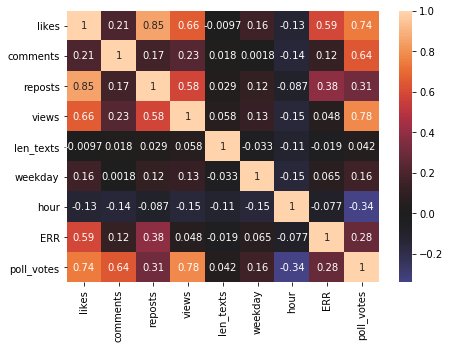

In [182]:
# можно взять все опросы из первых 500(и 2000) записей, и посмотреть на их охваты в зависимости от разных параметров.
df_polls = df.dropna() # None в таблице в строках, где нет голосование и, соответственно, голосов
df_polls
research_list = ["likes", "comments", "reposts", "views", "len_texts", "weekday", "hour", "ERR", "poll_votes"]
# df_polls[research_list].head()
corr_m = df[research_list].corr()
# corr_m
plt.figure(figsize=(7,5))
sns.heatmap(corr_m, center=0, annot=True)

# Лайки, количество просмотров, репосты, ERR и количество голосов связаны =)))
# но, например, от дня недели или часа публикации явной линейной зависимости не прослеживается.
# ниже посмотрим на диаграмму рассеяния, может быть есть нелинейная зависимость.

# в целом линейную зависимость смотреть нет большого смысла. Если зависимость и имеется, то она в данном случае нелинейная.

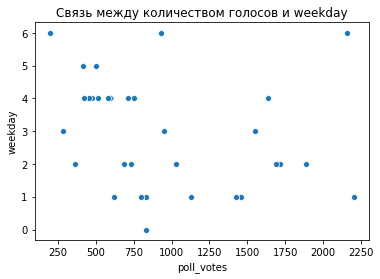

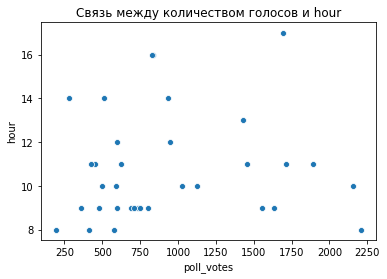

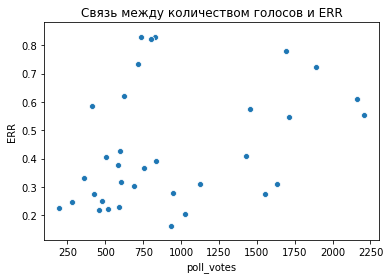

In [195]:
# выберем последние 180 дней, так как за годы ситуация может сильно меняться
# но за этот промежуток было не очень много опросов.
# research_list сделаем покороче
research_list = ["weekday", "hour", "ERR", "poll_votes"]
df_for_scatter = df[(df['date'] > (pd.to_datetime('now') - pd.Timedelta('365 days'))) & (df['poll_votes'] < 3000)]
for i in research_list[:-1]:
    sns.scatterplot(x="poll_votes", y=i, data=df_for_scatter)
    plt.title("Связь между количеством голосов и " + str(i))
    plt.show()
    
# так как больше 3000 голосов имеют всего 3 опроса - на них можно посмотреть отдельно.
# а какие-то зависимости искать по остальным опросам.

# опросы, опубликованные в вт, ср имели больший отклик по голосам, чем в пт, сб.
# по зависимости от часа публикации сложно сделать какой-то вывод, так как в первой половине дня 
# опросы публиковались чаще, и по ним есть как хороший, так и маленький отклик.
# а в 12 часов и позже опросы публиковались достаточно редко. Но можно сказать, что отклик по ним небольшой.

In [191]:
# эти опросы имеют больше 3000 голосов. Стоит проанализировать их отдельно.
# можно сказать, что опубликованы они были утром, во второй половине рабочей недели.
# особенно выделяется опрос от декабря 2019, который набрал почти 5000 ответов 
# при наименьшем из этих опросов количестве просмотров.
df[df['poll_votes'] > 3000]

,date,likes,comments,reposts,views,tags,len_texts,poll_votes,weekday,hour,ERR
33,2020-05-28 09:31:26,45,93,2,33940,"[#Дизайн_баттл, #Skillbox_дизайн]",424,3393.0,3,9,0.412493
87,2020-04-17 11:27:29,43,30,2,25185,[#Дизайн_баттл],464,3335.0,4,11,0.297796
331,2019-12-07 08:00:01,46,89,2,22938,"[#Design_Battle_Skillbox, #Skillbox_дизайн]",640,4955.0,5,8,0.597262


### Анализ данных

#### Опросы
* Так как больше 3000 голосов имеют всего 3 опроса - на них можно посмотреть отдельно. А какие-то зависимости искать по остальным опросам.
* Опросы, опубликованные во вт, ср имели больший отклик по голосам, чем в пт, сб.
* По зависимости от часа публикации сложно сделать какой-то вывод, так как в первой половине дня опросы публиковались чаще, и по ним есть как хороший, так и маленький отклик. А в 12 часов и позже опросы публиковались достаточно редко. Но можно сказать, что отклик по ним небольшой.
* Ниже выведены три опроса, которые набрали более 3000 голосов. Стоит проанализировать их отдельно.

In [192]:
# эти опросы имеют больше 3000 голосов. Стоит проанализировать их отдельно.
# можно сказать, что опубликованы они были утром, во второй половине рабочей недели.
# особенно выделяется опрос от декабря 2019, который набрал почти 5000 ответов 
# при наименьшем из этих опросов количестве просмотров.
df[df['poll_votes'] > 3000]

,date,likes,comments,reposts,views,tags,len_texts,poll_votes,weekday,hour,ERR
33,2020-05-28 09:31:26,45,93,2,33940,"[#Дизайн_баттл, #Skillbox_дизайн]",424,3393.0,3,9,0.412493
87,2020-04-17 11:27:29,43,30,2,25185,[#Дизайн_баттл],464,3335.0,4,11,0.297796
331,2019-12-07 08:00:01,46,89,2,22938,"[#Design_Battle_Skillbox, #Skillbox_дизайн]",640,4955.0,5,8,0.597262


#### Вывод по ERR в разрезе хэштегов
* Очень мало разделов в последние 60 дней, выделенных хэштегами. Хорошо бы разнообразить материал, если не предполагается, что ЦА паблика - в основном дизайнеры
* В_закладки_Skillbox - самый популярный с точки зрения вовлеченности хэштег в последние полгода. 
* Если говорить о более большом периоде - популярны посты, связанные с полезностю: "В закладки", "Полезное", "skillbox вдохновляет"


#### Просмотры  летом 2018-го года (там наблюдались пики)
* Можем увидеть, что в целом количество просмотров находятся в определённом диапазоне, и только единичные записи выделяются. Это могут быть рекламные записи
* Можно отметить, что записи, опубликованные в пт имели большее количество просмотров.
* Что касается времени, количество просмотров большее у публикаций, сделанных с 12 до 14 часов.
* Посты с разной длиной текста в основном имеют количество просмотров в пределах 20000. Но публикации, набиравшие от 40 до 80 тыс. просмотров имели от 300 до 800 знаков. То есть среднюю длину. Не самые короткие, но и не самые длинные.

Ниже представлена выборка пиковых по лайкам постов этого периода.

In [199]:
df[(df['date'] < pd.to_datetime('20180801')) & (df['views'] > 100000)]

,date,likes,comments,reposts,views,tags,len_texts,poll_votes,weekday,hour,ERR
1918,2018-07-11 12:30:01,210,5,39,103872,[#design@skillbox_education],497,NaN,2,12,0.244532
1995,2018-06-14 11:00:12,194,7,18,145399,[#read@skillbox_education],376,NaN,3,11,0.150620


А также все записи с количеством просмотров выше 100 000

In [200]:
df[(df['views'] > 100000)]

,date,likes,comments,reposts,views,tags,len_texts,poll_votes,weekday,hour,ERR
392,2019-11-10 09:35:11,68,34,3,122759,"[#Skillbox_Sreda, #Skillbox_конкурс]",607,NaN,6,9,0.085533
1918,2018-07-11 12:30:01,210,5,39,103872,[#design@skillbox_education],497,NaN,2,12,0.244532
1995,2018-06-14 11:00:12,194,7,18,145399,[#read@skillbox_education],376,NaN,3,11,0.150620


#### По длине текста
В целом по всем показателям (лайки, просмотры, ERR и т.д.) вовлеченность выше при длине текста (200)300-800(1000) символов (в скобках указаны значения, при которых вовлеченность, если и падает, то незначительно. В коротких постах и слишком длинных постах вовлеченность ниже.

#### По времени публикации
Первая половина дня более предпочтительна для публикации.
Середина дня (12-14 часов) наименнее предпочтительная для публикации. (Публикаций, сделанных очень рано утром и поздно вечером нет - поэтому для этих интервалов нет данных)